In [3]:
%matplotlib inline
import numpy
import scipy
import pylab
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import xml.etree.ElementTree as et
import pandas as pd
import glob
import numpy as np
import seaborn as sns

In [5]:
def load_matrix_and_labels(basefile):
    D = numpy.load(open(basefile, 'rb'))
    labeltext = [ x.strip() for x in open(basefile + '.labels.txt') ]
    return (D, labeltext)
def plot_composite_matrix(D, labeltext, show_labels=True, show_indices=True):
    if show_labels:
        show_indices=True
    D = numpy.array(D, copy=True)

    fig = pylab.figure(figsize=(11,8))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])

    # plot denderogram
    Y = sch.linkage(D, method='single') # centroid  
    
    dendrolabels = labeltext
    if not show_labels:
        dendrolabels = [ str(i) for i in range(len(labeltext)) ]
                        
    Z1 = sch.dendrogram(Y, orientation='right', labels=dendrolabels,
                        no_labels=not show_indices)
    ax1.set_xticks([])

    xstart = 0.45
    width = 0.45
    if not show_labels:
        xstart = 0.315
    scale_xstart = xstart + width + 0.01

    # plot matrix
    axmatrix = fig.add_axes([xstart,0.1, width,0.6])

    # (this reorders D by the clustering in Z1)
    idx1 = Z1['leaves']
    D = D[idx1, :]
    D = D[:, idx1]

    # show matrix
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu, vmin=0, vmax=1)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.                                                            
    axcolor = fig.add_axes([scale_xstart,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    
    # print labels, if not shown
    if not show_labels:
        for i, label in enumerate(labeltext):
            print('%d\t%s' % (i, label))

    return fig


def neighborhood(iterable):
    #get previous, current, and next part of iterator. 
    iterator = iter(iterable)
    prev_item = None
    current_item = next(iterator)  # throws StopIteration if empty.
    for next_item in iterator:
        yield (prev_item, current_item, next_item)
        prev_item = current_item
        current_item = next_item
    yield (prev_item, current_item, None)



In [11]:
tree = et.parse('sample-attributes/ERS477979.xml')

columns=[]
for elem in tree.iter():
#     print elem.tag, elem.attrib, elem.text
    if elem.tag.startswith('DB'):
        columns+=[elem.text]

    elif elem.tag.startswith('TAG'):
        columns+=[elem.text]

sampleAttributes=pd.DataFrame(columns=columns)    


for xmlfile in glob.glob('sample-attributes/*xml'):
    ersName = xmlfile.split('/')[1].split('.')[0]
    
    tree = et.parse(xmlfile)
    for prev_elem, elem, next_elem in neighborhood(tree.iter()):
        if elem.tag.startswith('DB'):
            colName = elem.text
            elem = next(tree.iter())
            val=next_elem.text
            sampleAttributes.loc[ersName,colName]=val
        elif elem.tag.startswith('TAG'):
            colName = elem.text
            elem = next(tree.iter())
            val=next_elem.text
            sampleAttributes.loc[ersName,colName]=val

for col in [ u'Size Fraction Lower Threshold', u'Size Fraction Upper Threshold', u'Latitude Start', u'Longitude Start', u'Latitude End', u'Longitude End', 
            u'Depth',u'Salinity Sensor', u'Oxygen Sensor', u'Nitrate Sensor', u'Chlorophyll Sensor',]:
    sampleAttributes[col]=pd.to_numeric(sampleAttributes[col])
    
    
sungawa=pd.read_csv('tara-analyses/Sunagawa_TableS1.csv', index_col='INSDC sample accession number(s)')
cols = ['Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
        'Marine provinces  (Longhurst 2007)', 'Environmental Feature']
sampleAttributes=sampleAttributes.merge(sungawa[cols], 
                       left_index=True, right_index=True)
sampleAttributes.columns=[u'ENA-STUDY', u'ENA-EXPERIMENT', u'ENA-RUN', u'ENA-SUBMISSION',
       u'ENA-FASTQ-FILES', u'ENA-SUBMITTED-FILES', u'Sampling Campaign',
       u'Sampling Station', u'Sampling Platform', u'Event Label',
       u'Event Date/Time Start', u'Event Date/Time End', u'Latitude Start',
       u'Longitude Start', u'Latitude End', u'Longitude End', u'Depth',
       u'Sample Collection Device', u'Protocol Label',
       u'Size Fraction Lower Threshold', u'Size Fraction Upper Threshold',
       u'Sample Status', u'Last Update Date', u'Marine Region', u'Temperature',
       u'Salinity Sensor', u'Oxygen Sensor', u'Nitrate Sensor',
       u'Chlorophyll Sensor', u'Environment (Biome)', u'Environment (Feature)',
       u'Environment (Material)', u'Environmental Package', u'Citation',
       u'Further Details', u'Project Name', u'ENA-CHECKLIST',
       u'ENA-SPOT-COUNT', u'ENA-BASE-COUNT', u'ENA-FIRST-PUBLIC',
       u'ENA-LAST-UPDATE',
       u'Ocean regions',
       u'Marine provinces', u'Environmental Feature']
sampleAttributes['ORs']=sampleAttributes['Ocean regions'].str.replace(r'\).*', '').str.replace('(', '')
sampleAttributes['EFs']=sampleAttributes['Environmental Feature'].str.replace(r'\).*', '').str.replace('(', '')

lst_col = 'ENA-RUN'
x = sampleAttributes.assign(**{lst_col:sampleAttributes[lst_col].str.split(',')})
ERA_sampleAtr=pd.DataFrame({col:np.repeat(x[col].values, x[lst_col].str.len()) for col in x.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(
            x[lst_col].values)})[x.columns.tolist()]
ERA_sampleAtr=ERA_sampleAtr.set_index('ENA-RUN')

In [12]:
D_filename = 'sourmash-sigs/abundtrim.dist'

D, labeltext = load_matrix_and_labels(D_filename)
labeltext=[label.split('_')[0] for label in labeltext]
abundTrim=pd.DataFrame(data=D, index=labeltext, columns=labeltext)


In [116]:
ERA_sampleAtr=ERA_sampleAtr[['ORs','EFs', 'Sampling Station']]
abundTrim2=abundTrim.merge(ERA_sampleAtr, left_index=True, right_index=True)


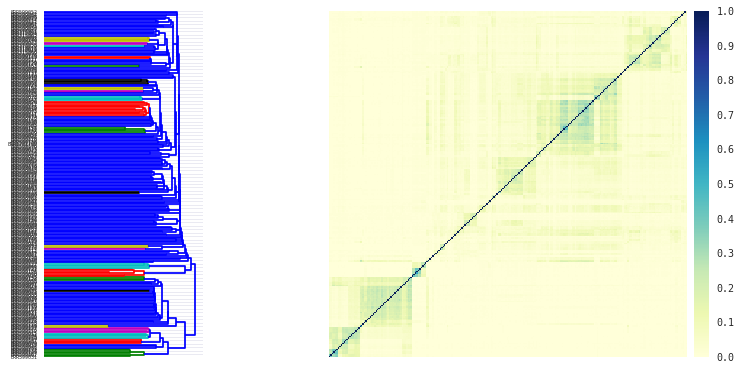

In [117]:
# labeltext=list(abundTrim2['ORs'])
for i in range(len(labeltext)):
    if i % 2:
        labeltext[i] = labeltext[i]
_ = plot_composite_matrix(D, labeltext)
# pylab.savefig('sourmash.png')


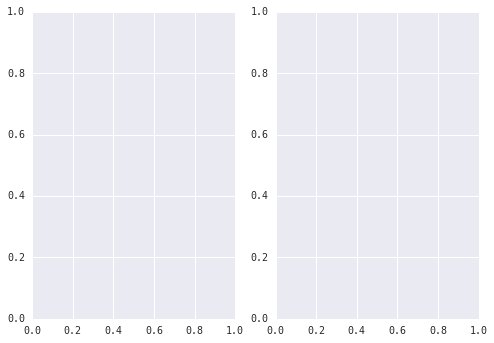

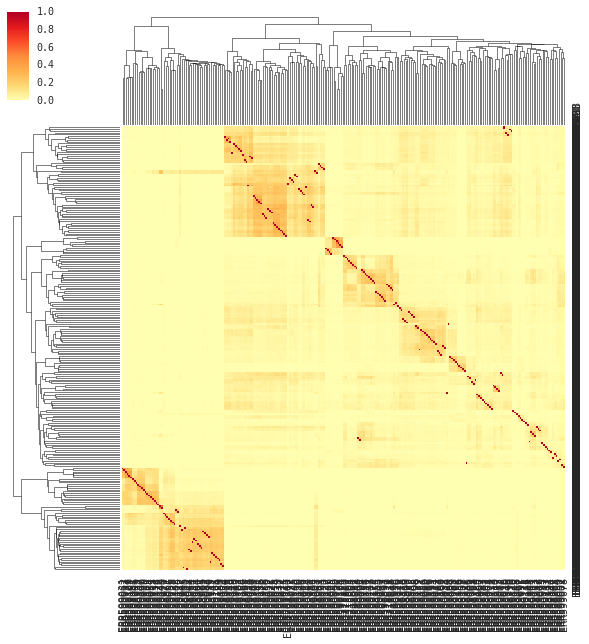

In [150]:
import palettable as pal
# create dictionary with value to integer mappings
df=abundTrim2[['ORs','EFs']]

for col in ['ORs','EFs']:
    value_to_int = {value: i for i, value in enumerate(sorted(pd.unique(df[col].values.ravel())))}
    df=df.replace(value_to_int)
# f, ax = plt.subplots()
# hm = sns.heatmap(df.replace(value_to_int).T, cmap="Pastel2", ax=ax, cbar=False)

fig, axs = plt.subplots(1,2)

g=sns.clustermap(abundTrim, cmap=pal.colorbrewer.sequential.YlOrRd_7.get_mpl_colormap())
# axs[1].set_xticklabels('')
# axs[1].set_yticklabels('')

# sns.heatmap(df.loc[abundTrim.index], cmap='Pastel2', ax=axs[0], cbar=False)
# axs[0].set_yticklabels('')

[]

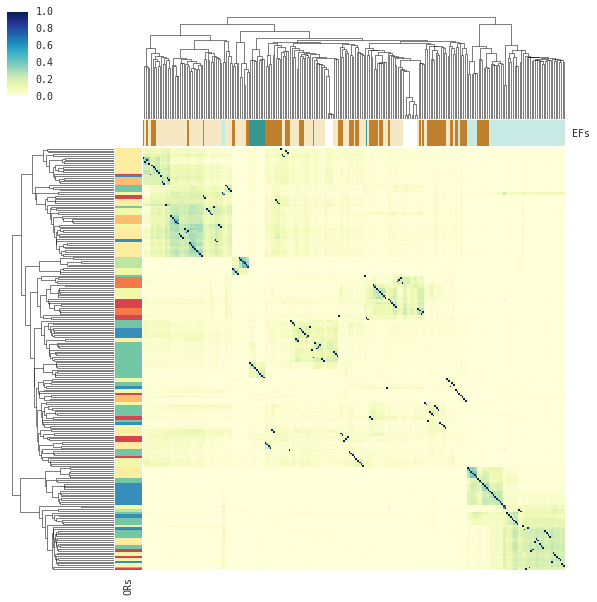

In [168]:
#color by region
network_pal=sns.color_palette('Spectral', len(abundTrim2.ORs.unique()))
network_lut = dict(zip(abundTrim2.ORs.unique(), network_pal))
networks = abundTrim2.ORs
network_colors = pd.Series(networks).map(network_lut)
#color by environmental factor
network_pal=sns.color_palette('BrBG', len(abundTrim2.EFs.unique()))
network_lut = dict(zip(abundTrim2.EFs.unique(), network_pal))
networks = abundTrim2.EFs
network_colors2 = pd.Series(networks).map(network_lut)
#plot cluster map
o=sns.clustermap(abundTrim2.iloc[:,:-3], row_colors=network_colors, col_colors=network_colors2,cmap="YlGnBu")
o.ax_heatmap.set_xticklabels('')
o.ax_heatmap.set_yticklabels('')

In [161]:
abundTrim2.EFs.unique()

array(['DCM', 'SRF', 'MES', 'MIX'], dtype=object)

In [149]:
networks

0     water
1      soil
2       air
3     water
4       air
5     water
6      soil
7       air
8      soil
9      soil
10    water
11    water
Name: Source, dtype: object

In [134]:
abundTrim2.iloc[:,1:10]

,ERR315858,ERR315859,ERR315860,ERR315861,ERR315862,ERR315863,ERR318618,ERR318619,ERR318620
ERR598950,0.033682,0.085947,0.083624,0.033682,0.026713,0.026713,0.068525,0.049942,0.068525
ERR599095,0.030733,0.082742,0.095745,0.026005,0.030733,0.031915,0.066194,0.053191,0.065012
ERR598955,0.098206,0.089707,0.099150,0.109537,0.095373,0.090652,0.184136,0.135977,0.191690
ERR599003,0.088044,0.094532,0.099166,0.103800,0.090825,0.087118,0.186284,0.134384,0.186284
ERR599073,0.097656,0.098633,0.101562,0.102539,0.111328,0.108398,0.227539,0.161133,0.216797
ERR599092,0.097752,0.124145,0.119257,0.103617,0.110459,0.105572,0.231672,0.163245,0.234604
ERR598993,0.123618,0.129648,0.113568,0.119598,0.138693,0.128643,0.247236,0.165829,0.241206
ERR599140,0.128392,0.129436,0.121086,0.128392,0.145094,0.130480,0.256785,0.174322,0.253653
ERR315858,1.000000,0.171304,0.172174,0.251304,0.206087,0.214783,0.198261,0.130435,0.180000
ERR315861,0.235342,0.162052,0.166124,1.000000,0.210098,0.207655,0.180782,0.112378,0.180782


In [79]:
df.loc[abundTrim.index]

,ORs,EFs
ERR1701760,NaN,NaN
ERR315858,1.0,3.0
ERR315859,NaN,NaN
ERR315860,NaN,NaN
ERR315861,1.0,3.0
ERR315862,NaN,NaN
ERR315863,NaN,NaN
ERR318618,NaN,NaN
ERR318619,NaN,NaN
ERR318620,NaN,NaN


In [65]:

a

,ORs,EFs
ERR1701760,NaN,NaN
ERR315858,1.0,3.0
ERR315859,NaN,NaN
ERR315860,NaN,NaN
ERR315861,1.0,3.0
ERR315862,NaN,NaN
ERR315863,NaN,NaN
ERR318618,NaN,NaN
ERR318619,NaN,NaN
ERR318620,NaN,NaN


In [116]:
# D_filename = 'sourmash-sigs/raw-reads.dist'

# D, labeltext = load_matrix_and_labels(D_filename)
# labeltext=[label.split('_')[0] for label in labeltext]

# # relabel the trimmed ones as 'trim' - they're the ones with trim in the filename ;)
# for i in range(len(labeltext)):
#     if i % 2:
#         labeltext[i] = labeltext[i]
# _ = plot_composite_matrix(D, labeltext)
# pylab.savefig('sourmash.png')


## Parse out the data from the xml files for the ocean samples. 

ImportError: No module named seaborn